Taking the Data from Yahoo Finance 

# SIMPLE MOVING AVERAGE 

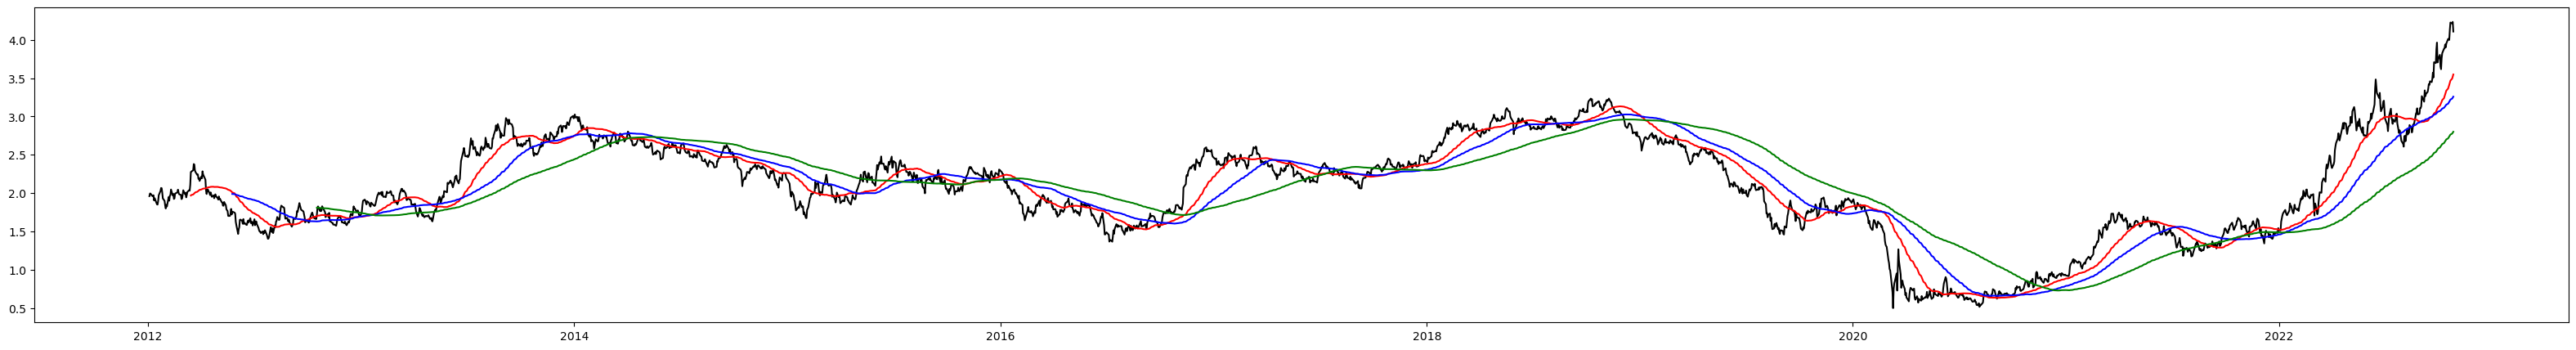

In [1]:


import datetime as dt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


ticker = '^TNX'
start = dt.datetime(2012,1,1)
end = dt.datetime(2022,10,25)

history = web.DataReader(ticker, 'yahoo', start=start, end=end)
history = history.loc[:, ['Open', 'Close']]
history.head()



history['Previous_Close'] = history.loc[:, 'Close'].shift(1)  #First Indicator 
# display(history)

datetimes = history.index.values #Second Indicator 
weekdays = []

for dt in datetimes:
    dt = datetime.strptime(str(dt), '%Y-%m-%dT%H:%M:%S.000000000')
    weekdays.append(dt.weekday())


history['Weekday'] = weekdays

history['50SMA'] = history['Previous_Close'].rolling(50).mean()
history['100SMA'] = history['Previous_Close'].rolling(100).mean()
history['200SMA'] = history['Previous_Close'].rolling(200).mean()


x = history.index.values # X values is the overall time 


plt.figure(figsize=(40,5))
plt.plot(x, history['Previous_Close'], color = 'black')
plt.plot(x, history['50SMA'], color = 'red')
plt.plot(x, history['100SMA'], color = 'blue')
plt.plot(x, history['200SMA'], color = 'green')


# if red is below the green line: short term we are going to be negative while long term is stil positive (T BOND IS trending downwards). VISE VERSA 

## MCD Method

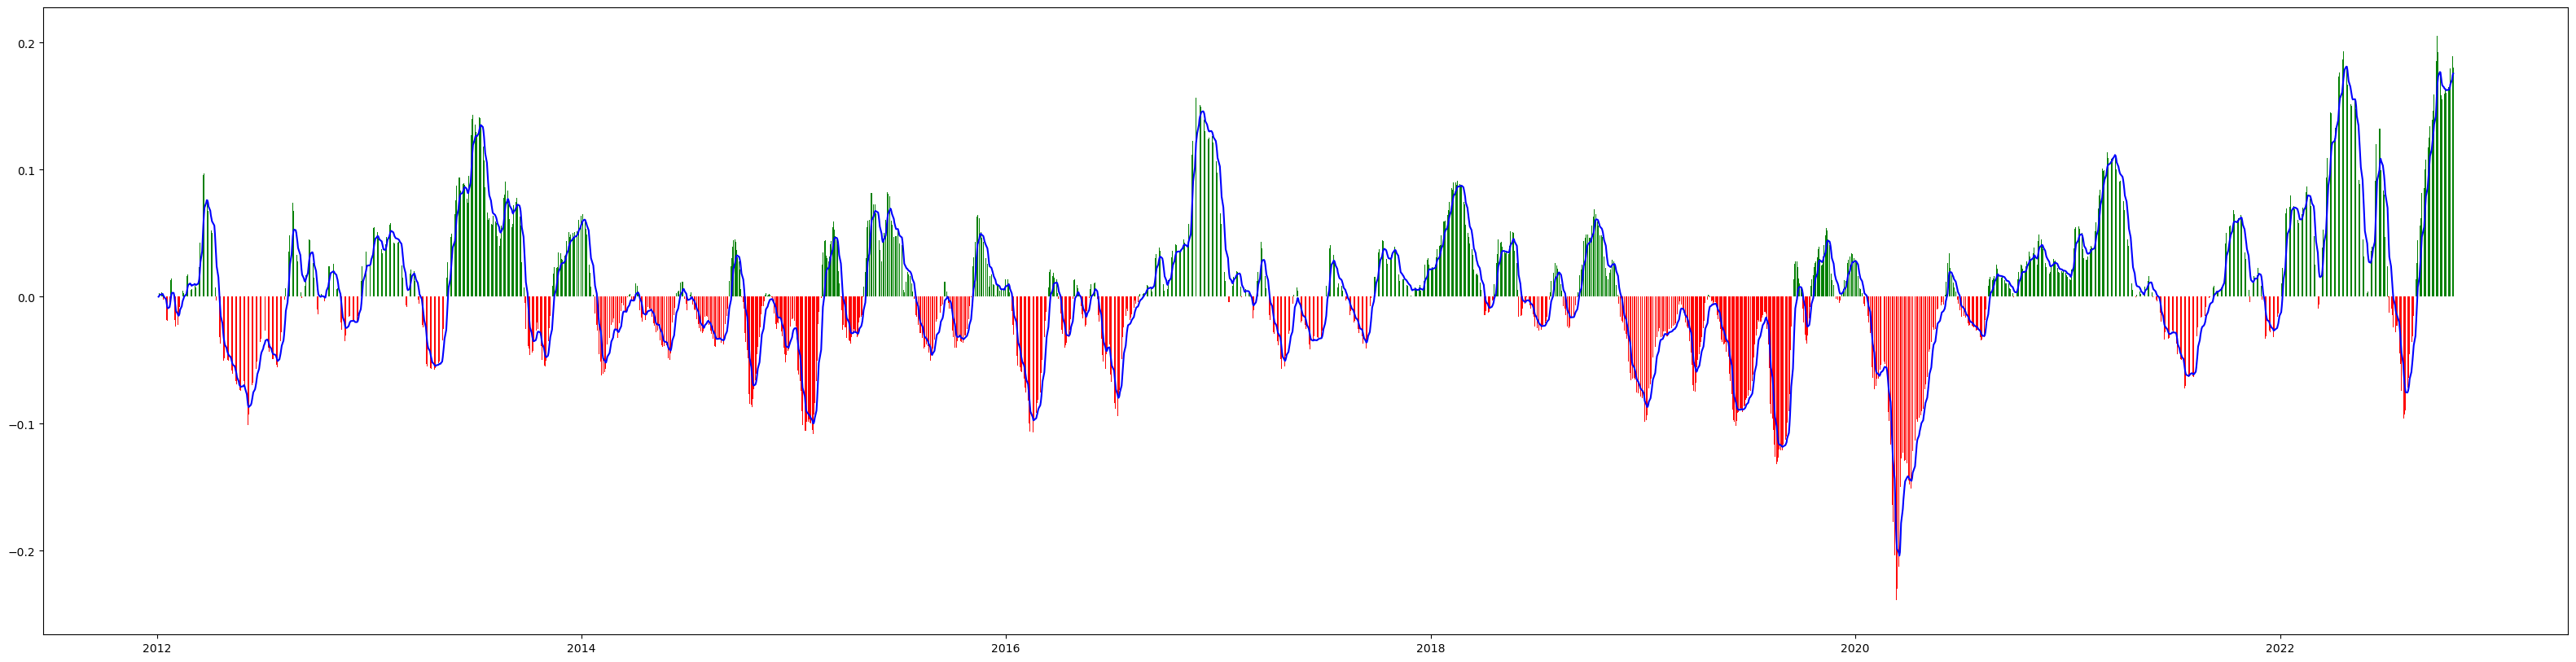

In [2]:
def calc_macd(data, len1, len2, len3):   ### Moving average but with exponential 
    shortEMA = data.ewm(span = len1, adjust =False).mean()
    longEMA = data.ewm(span = len2, adjust= False).mean()
    MACD = shortEMA - longEMA
    signal = MACD.ewm(span = len3, adjust= False).mean()
    return MACD, signal


MACD, signal = calc_macd(history['Previous_Close'], 12, 26 , 9) ### Need to check on the numbers here 
history['MACD'] = MACD
history['MACD_signal'] = signal

x = history.index.values # X values is the overall time 

plt.figure(figsize=(40,10))

colors = np.array(['green'] * len(history['MACD']))
colors[history['MACD'] < 0 ] = 'red'
plt.bar(x, history.MACD, color= colors)
plt.plot(x, history.MACD_signal, color= 'blue')
plt.show()

# BOLLINGER METHOD, CALCULATING THE MAXIMUM AND MINIMUM POINT

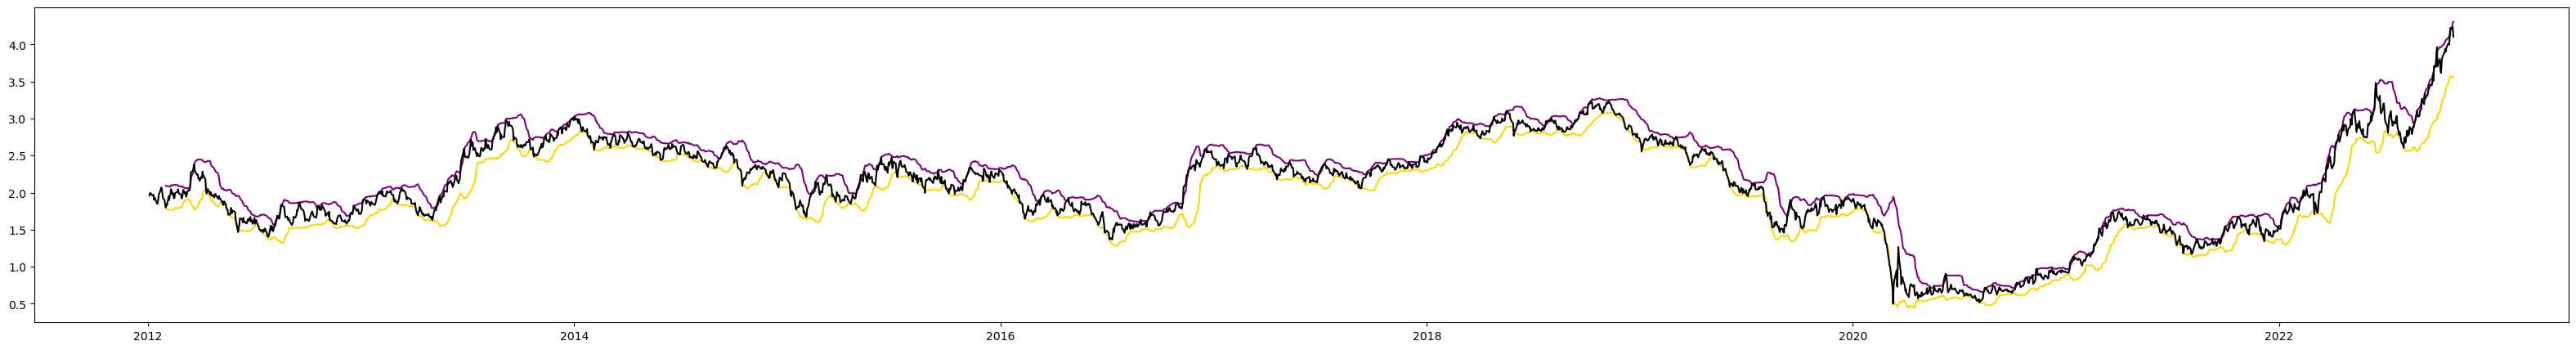

In [3]:
def calc_bollinger(data, period):
    mean = data.rolling(period).mean()
    SD = data.rolling(period).std()
    upper_band = np.array(mean) + 2 * np.array(SD)
    lower_band = np.array(mean) - 2 * np.array(SD)
    return upper_band, lower_band


upper, lower = calc_bollinger(history['Previous_Close'], 20) ##We can play around the number. THe number is days lookback (need to check)
history['Upper_Band'] = upper
history['Lower_Band'] = lower 

x = history.index.values # X values is the overall time 

plt.figure(figsize=(40,5))
plt.plot(x, history['Upper_Band'], color = 'purple') #Max
plt.plot(x, history['Lower_Band'], color = 'gold')  #Min


plt.plot(x, history['Previous_Close'], color = 'black')




plt.show()

## Linear Regression

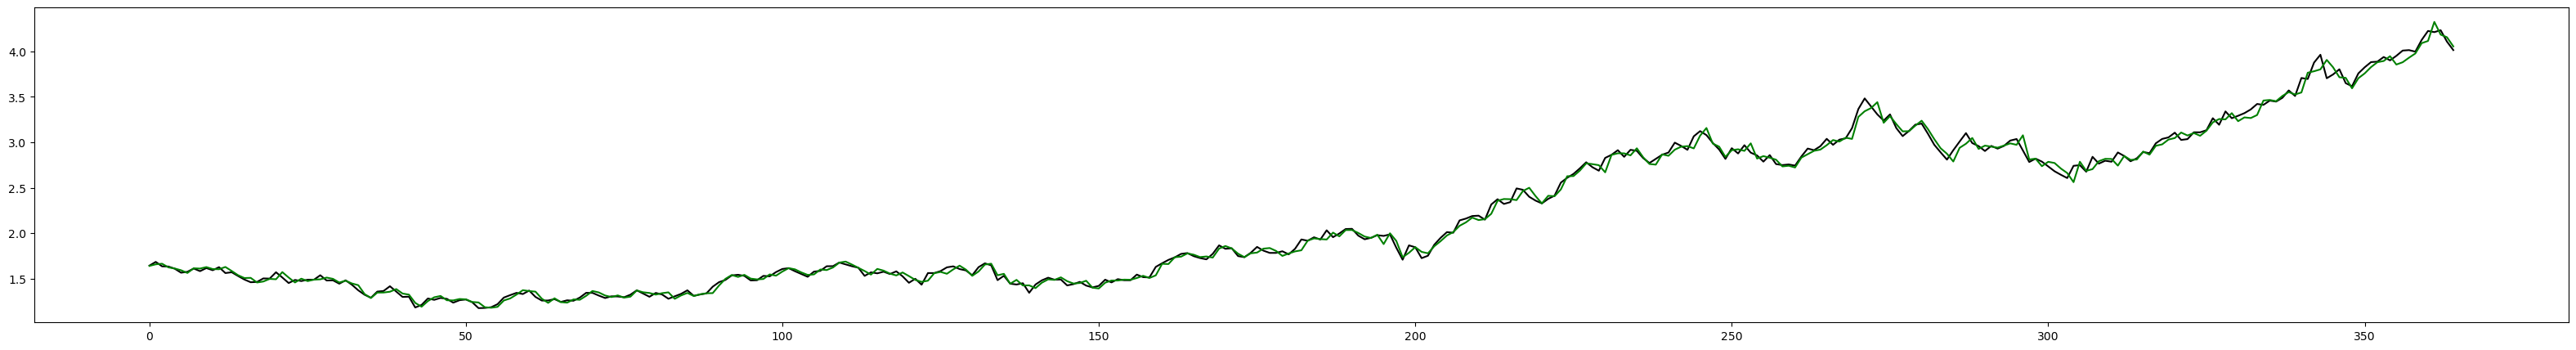

In [4]:
from sklearn.linear_model import LinearRegression

#Preparing the Data from Previous Session 

history = history.replace(np.inf, np.nan).dropna() #Replacing infinite values to NA, and then dropping all NA. 
#Linear Regression will not take NA values kindly 



y = history['Close'] #The value that we wants to predict
x = history.drop('Close', axis = 1 ) #Dropping the Close since this is the value that we wants to predict


# Split the Data to Train and Test 

number_day_test = 365  # we want to get the 1 year of data 

x_train = x[:-1*number_day_test] #training the data from beginning of 2012 to 1 year before the current day
y_train = y[:-1*number_day_test]

x_test = x[-1*number_day_test:]
y_test = y[-1*number_day_test:]

# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) #checking if the shape is okay to train

linear_model = LinearRegression()
linear_model = linear_model.fit(x_train, y_train)
preds = linear_model.predict(x_test)


plt.figure(figsize=(40,5))
plt.plot(range(len(y_test)), y_test, color = 'black')
plt.plot(range(len(preds)), preds, color = 'green')
plt.show()


In [35]:
preds[-1]

4.05582989850223